In [2]:
import pandas as pd
import jieba
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

pd.set_option('display.max_colwidth', None)#setting the maximize string show

fb = pd.read_csv('nysu_10902_2019立委_research.csv')
politics = pd.read_csv('9th_legislator_promise.csv')

In [3]:
zhao = fb[fb.page_name == "趙天麟"]

# 依照按讚數 低到高排序
zhao = zhao.sort_values(by=['like_count'])
# 用新的排序當作順序
zhao.reset_index(inplace=True)

# 把時間格式轉換
zhao['new_date'] = pd.to_datetime(zhao['created_time_taipei']).dt.date
zhao['post_hour'] = pd.to_datetime(zhao['created_time_taipei']).dt.hour #找出發文 '時間'(hour)
zhao['month_year'] = pd.to_datetime(zhao['new_date']).dt.to_period('M')

zhao.head(1)

,index,post_id,page_id,page_name,page_category,message,story,type,permalink,created_time_gmt,...,haha_count,love_count,angry_count,sad_count,wow_count,comment_count,share_count,new_date,post_hour,month_year
0,2223,109004835824305_2469461533111945,109004835824305,趙天麟,政治人物,NaN,趙天麟新增了 55 張相片。,photo,https://www.facebook.com/skychao6238/photos/a.2469461299778635/2469461533111945/?type=3,2019-08-10T13:24:46+0000,...,0,0,0,0,0,1,1,2019-08-10,21,2019-08


In [4]:
doc_names = range(len(zhao)) #有幾篇文章 : 528 篇文章
doc_names

range(0, 613)

結巴斷詞 jieba

len(liu): 看劉櫂豪的貼文總共有幾筆
list(liu['message']): 把要斷詞的內容轉成 list 格式
創造一個新的dataframe叫做liu_docs，型態是pandas.core.frame.DataFrame
原本liu_docs裡面的'jieba_results'欄位型態是pandas.core.series.Series，需要轉成'str'(字串)型態才能做後續處理。

In [7]:
import numpy as np
zhao = zhao.replace(np.nan, '', regex=True) #將nan取代成空白字串

text_list = list(zhao['message'])
# 把所有message轉成一個list 用for iterate

In [8]:
words = jieba.lcut(text_list[1], cut_all = False)
print(words)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\yangs\AppData\Local\Temp\jieba.cache
Loading model cost 0.667 seconds.
Prefix dict has been built successfully.


['「', '親子', '共讀', '要', '從', '幾歲', '開始', '呀', '？', '」', '\n', '「', '我', '的', '孩子', '根本', '坐不住', '要', '怎麼', '親子', '共讀', '？', '」', '\n', '\n', '國民', '健康', '署', '明天', '中午', '12', '點', '30', '分來', '為', '大家', '解惑', '\n', '請鎖定', '👉', 'https', ':', '/', '/', 'pse', '.', 'is', '/', 'G6UFJ', '\n', '\n', '#', '加碼', '抽獎', '活動', '\n', '#', '親子', '共讀']


In [9]:
words = jieba.lcut(text_list[527], cut_all = False)
print(words)

['曬', '曬', '全家', '肚肚照', '👶', '🏻', '💕', '\n', '#', '天天', '期待', '阿諾弟', '到', '來', '的', '我們', '這', '一家']


把要存斷詞結果的dataframe準備好之後，就可以開始斷詞了。</br>

第一個迴圈</br> 剛才我們知道，劉櫂豪的篇數有999篇： 我們可以用一個for迴圈來跑每一篇文章，i是對應文章的意思，會從1(第一篇)跑到999(第999篇)；</br> 而text_list就是我們剛剛轉成list型態的劉櫂豪貼文內容；text_list[1]，就是取出list第一個元素(第一篇貼文)的意思。</br>

第二個迴圈</br> words存的是文章斷詞後的集合物件(object)，我們需要跑第二個for迴圈把集合裡面的字取出來，</br> word代表斷詞集合中的一個字，先把字轉換成str(字串)型態之後，字和字之間加上空格存在一起。

append加回斷詞欄位</br> 之後把text內容存到'jieba_results'這個欄位裡面，再和liu_docs合併。</br> 最後我們liu_docs，只會一個欄位jieba_results，存斷詞之後的結果。

In [10]:
import jieba
from tqdm import tqdm
import re
jieba.load_userdict("dict.txt")
punctuation = " //，：:""()\n!！？｡＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘'‛“”„‟…‧﹏"""
re_punctuation = "[{}] ".format(punctuation)

# creat a df to store the jieba result
zhao_docs = pd.DataFrame(columns=['jieba_results']) # 建立df
zhao_docs['jieba_results'] = zhao_docs['jieba_results'].astype('str')

for i in doc_names: #從第一篇到最後一篇
    words = jieba.cut(text_list[i], cut_all = False)
    text = ''
    for word in words:
        text = text + ' ' + str(word) 
    #print(words)
    #print(i) #第幾篇文章
    #print(text) #第幾篇文章的斷詞結果
    text = re.sub(re_punctuation, "", text) # 把上面那些符號從text中刪掉
    text = re.sub(r'[0-9]','',text) # 刪掉數字
    text = re.sub(r'[a-zA-Z]','',text) #刪掉英文字
#刪除文字 更多標點符號
    text = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗🎉⏰💪]','',text)  # 注意裡面不能有空白！
    s = pd.Series({'jieba_results': text})
    zhao_docs = zhao_docs.append(s, ignore_index=True)#每次的斷詞結果都加回liu_docs

In [11]:
zhao['jieba_results'] = zhao_docs
zhao_post = zhao[['new_date','message','jieba_results','like_count']]
zhao_post

,new_date,message,jieba_results,like_count
0,2019-08-10,,,29
1,2019-06-18,「親子共讀要從幾歲開始呀？」\n「我的孩子根本坐不住要怎麼親子共讀？」\n\n國民健康署明天中午12點30分來為大家解惑\n請鎖定👉https://pse.is/G6UFJ\n\n#加碼抽獎活動\n#親子共讀,親子 共讀 要 從 幾歲 開始 呀 我 的 孩子 根本 坐不住 要 怎麼 親子 共讀 國民 健康 署 明天 中午 點 分來 為 大家 解惑 請鎖定 👉 加碼 抽獎 活動 親子 共讀,70
2,2019-01-03,,,84
3,2019-01-24,雅慧議員當選後首次直播，朋友們一起來為「星願烏克麗麗樂團」加油💪,雅慧議員 當選 後 首次 直播 朋友 們 一起 來 為 星願 烏克麗麗樂團 加油,122
4,2019-04-18,🎥直播預告21:00\n如果說今天的大地震嚇了你一跳，那麼重量級優質國片被盜版洩漏，就更是一場智慧財產的震撼！\n\n『盜版影片三不原則』：不看！不點！不散播！\n一起堅持看正版，讓本週日的精采大結局留下完美的句點！\n\n稍後21:00，天麟邀請到幾位朋友，他們正是『與惡』距離最近的一群人，有在追劇的朋友一起來聊聊真實的人生劇場吧。\n\n#這個時間我與餓也滿近的 😜\nhttps://reurl.cc/pK9W8,🎥 直播 預告 如果 說 今天 的 大 地震 嚇了 你 一 跳 那麼 重量 級 優質 國片 被 盜版 洩漏 就 更是 一場 智慧 財產 的 震撼 盜版 影片 三 不 原則 不看 不點 不 散播 一起 堅持 看 正版 讓 本 週日 的 精采 大結局 留下 完美 的 句點 稍 後 天麟 邀請 到 幾位 朋友 他們 正是 與 惡 距離 最近 的 一群 人 有 在 追劇 的 朋友 一起 來 聊聊 真實 的 人生 劇場 吧 這個 時間 我 與 餓 也 滿近 的 😜,150
...,...,...,...,...
608,2019-10-26,#謝謝今天所有出席的真勇者\n\n真勇者說的不僅僅是今天特地從台中到高雄為我助選的陳柏惟；說的不僅僅是今天站在台上的高雄市議員們，更是今天前金、新興所有的後援會會長、總幹事、副會長們，他們很多人都是現任里長，在市政府換黨執政下，他們具名並且願意站出來支持我，他們也是真勇者。\n\n我也要特別感謝管碧玲委員，我們的管媽，她是一個有智慧，有氣度的長者，由於選區合併，她在今年3月率先宣布放棄連任，讓天麟可以提早經營選區。相信管媽要以豐富的選戰經驗，帶領我們翻轉高雄，打出一場漂亮的勝仗。\n\n陳柏惟在台上，看到現場這麼多市民朋友的熱情，流下了英雄淚，陳柏惟說天麟有強大意志力，天麟是一個馬拉松跑者，我挑戰100公里超級馬拉松，我要做到的事情一定會做到。\n\n文益議員說天麟的選舉很正向，都在傳遞正能量，不攻擊別人，不做負面文宣。今年這場選戰，讓天麟想起9年前的自己。當時我的競選對手是邱毅，大家都叫他「爆料天王」，是一個強勁的對手。天麟當時決定參選立委，宣布不參選議員連任，全力輔選我們這區的市議員，讓我們民進黨在2010年的議會選舉，在第8選區揮出全壘打。也感謝建盟議員等夥伴，全力輔選，讓天麟挑戰成功。\n\n為了紮根基層，提供最接地氣的服務，天麟推動跟里長設立「聯合服務處」。過去天麟在前新苓共同建立將近100個聯合服務處，也跟各區的資深里長一起合作，培育了許許多多的新好里長。我們也從這些跟里長合作完成許多選民服務，也爭取到不少重大建設。\n \n除了貼近選民，提供優質服務外，天麟在立法院歷任衛環委員會、內政委員會及外交國防委員會，並擔任召委，也被公督盟評為優秀立委。天麟重視國際事務及兩岸議題，曾應美國國務院之邀訪問研究，並到日本慶應大學就國際事務及兩岸問題交換意見跟學習。同時，天麟也曾在民進黨中央黨部擔任過青年部主任、新聞部主任以及小英總統擔任黨主席後兩任中國事務部主任，用國際角度看台海問題，全力協助蔡總統建立國際及兩岸論述。在離選戰倒數78天之際，天麟依舊堅守在外交國防委員會，捍衛F16V戰機的預算及強化國安的法案，替小英總統完成抗中保台的任務。\n \n天麟也要特別感謝許多好朋友出席，永達兄特地來支持我，蔡昌達前副議長特別來關心我的選情，後援總會許文欽總會長是我永遠的後盾，後援總會總幹事陳福明協助今天的所有一切，更要感謝前金後援會會長賴勇村及新興後援會會長謝國男所組織的後援會系統。今天距離選舉還有最後77天，台灣要贏，高雄一定要大贏，高雄第六選區如果大贏，高雄市就可以八仙過海，立委通通過關，拜託大家，跟著天麟一起衝，最後77天，我們一直衝！一起衝！\n\n#一人拉一票台中第二選區陳柏惟\n#感謝管媽3Q哥\n#特別感謝蕭永達出席\n#記得我們的微笑手勢\n#謝謝邁家人TaiwanTeam天粉出任務志工夥伴\n#感謝製作天麟手舉牌氣氛超好\n\n3Q 陳柏惟\n管碧玲 (kuanbiling)\n萬事發達蔡昌達\n煥然一新 簡煥宗\n益起打拚－黃文益\n主婦政治力 李雅慧\n鳳山要紅 林智鴻\n高雄市議員鄭孟洳\n高雄市議員郭建盟\n江瑞鴻\n李喬如\n黃秋媖 高雄市議員\n蕭永達,謝謝 今天 所有 出席 的 真 勇者 真 勇者 說 的 不僅僅 是 今天 特地 從台 中到 高雄為 我助 選 的 陳 柏惟 說 的 不僅僅 是 今天 站 在 台上 的 高雄市 議員們 更是 今天 前金 新興 所有 的 後 援會會長 總幹事 副會長 們 他們 很多 人 都 是 現任 里 長 在 市政府 換黨 執政下 他們 具名 並且 願意 站 出來 支持 我 他們 也 是 真 勇者 我 也 要 特別 感謝 管碧玲 委員 我們 的 管媽 她 是 一個 有 智慧 有氣度 的 長 者 由 於 選區合 併 她 在 今年 月 率先 宣布 放棄 連任 讓 天麟 可以 提早 經營 選區 相信 管媽 要 以 豐富 的 選戰 經驗 帶領 我們 翻 轉高雄 打出 一場 漂亮 的 勝仗 陳 柏惟 在 台上 看到 現場 這麼 多 市民 朋友 的 熱情 流下 了 英雄 淚 陳 柏惟說 天麟 有 強大 意志力 天麟 是 一個 馬拉松 跑者 我 挑戰 公里 超級 馬拉松 我要 做到 的 事情 一定 會 做到 文益 議員 說 天麟 的 選舉 很 正向 都 在 傳遞 正 能量 不 攻擊別 人 不 做 負面 文宣 今年 這場 選戰 讓 天麟 想起 年前 的 自己 當時 我 的 競選 對 手 是 邱毅 大家 都 叫 他 爆料 天王 是 一個 強勁 的 對 手 天麟 當時 決定 參選 立委 宣布 不 參選議員 連任 全力 輔選 我們 這區 的 市議員 讓 我們 民進 黨 在 年 的 議會 選舉 在 第 選區 揮出 全壘 打 也 感謝 建盟 議員 等 夥伴 全力 輔選 讓 天麟 挑戰 成功 為 了 紮 根基 層 提供 最 接地 氣的 服務 天麟 推動 跟 里 長 設立 聯合 服務 處 過去 天麟 在 前 新苓 共同 建立 將近 個 聯合 服務 處 也 跟 各區 的 資深里長 一起 合作 培育 了 許許 多多 的 新 好 里 長 我們 也 從 這些 跟 里 長 合作 完成 許多 選民服務 也 爭取 到 不少 重大 建設 除了 貼近 選民 提供 優質 服務 外 天麟 在 立法院 歷任 衛環 委員 會 內 政委 員會 及 外交國防委員會 並擔 任召委 也 被 公督盟 評為 優秀 立委 天麟 重視 國際 事務及 兩岸 議題 曾應 美國 國務院 之 邀訪問 研究 並到 日本 慶應 大學 就 國際 事務及 兩岸 問題 交換 意見 跟 學習 同時 天麟 也 曾 在 民進 黨 中央 黨部擔 任過 青年 部 主任 新聞部 主任 以及 小英總統 擔任 黨 主席 後 兩任 中國 事務部 主任 用國際 角度看 台海 問題 全力 協助 蔡總統 建立 國際及 兩岸 論述 在 離 選戰 倒數 天之際 天麟 依舊 堅守 在 外交國防委員會 捍衛 戰機 的 預算及 強化 國安 的 法案 替 小英總統 完成 抗 中保 台 的 任務 天麟 也 要 特別 感謝 許多 好 朋友 出席 永達兄 特地 來 支持 我 蔡昌達 前 副 議長 特別 來 關心 我 的 選情 後 援 總會 許文欽 總會長 是 我永遠 的 後 盾 後 援 總會 總幹事 陳 福明 協助 今天 的 所有 一切 更要 感謝 前 金後援 會會長 賴勇村 及 新 興後援 會會長 謝國 男 所 組織 的 後 援會 系統 今天 距離 選舉 還有 最 後 天 台灣 要贏 高雄 一定 要大贏 高雄 第六 選區 如果 大贏 高雄市 就 可以 八仙 過海 立委 通通 過關 拜 託 大家 跟 著 天麟 一起 衝 最 後 天 我們 一直 衝 一起 衝 一人拉 一票 台 中 第二 選區 陳 柏惟 感謝 管媽 哥 特別 感謝 蕭永達 出席 記得 我們 的 微笑 手勢 謝謝邁 家人 天粉 出任 務志 工夥伴 感 謝 製 作 天 麟 手 舉 牌 氣 氛 超 好 陳 柏惟 管碧玲 萬事 發達 蔡昌達 煥然 一新 簡煥宗 益起 打 拚 黃 文益 主婦 政治 力 李雅慧 鳳山 要紅 林智鴻 高雄市 議員 鄭孟 洳 高雄市 議員 郭建盟 江瑞鴻 李喬如 黃 秋 媖 高雄市 議員 蕭永達,19978
609,2019-11-28,經過了8年的努力，「壽山自然公園籌備處」終於以「國家自然公園管理處」正式揭牌成立！\n\n「國家公園」是台灣重要的生態標記，但屬於淺山型的都會山區與公園，卻無法在國家公園與一般社區公園做出區隔

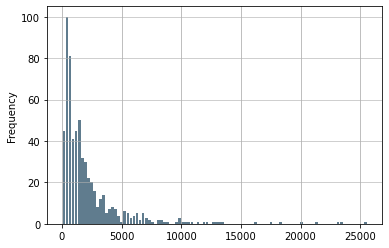

In [12]:
commutes = zhao_post['like_count']
commutes.plot.hist(grid=True, bins=100, rwidth=0.9,
color='#607c8e')
plt.grid(axis='y', alpha=0.75)

In [13]:
temp = zhao_post[(zhao_post['like_count'] <= 10000) & (zhao_post['like_count'] > 500)]
temp

,new_date,message,jieba_results,like_count
127,2019-09-18,大家覺得韓國瑜接下來會⋯,大家 覺得 韓國瑜 接下 來會,502
128,2019-01-20,2009年，志偉是我青年部幹部，我們一起赴屏東救災；2019年，志偉是立委補選候選人，我北上陪他到菜市場拉票。\n\n#補選第一戰全台都在看何志偉凍蒜,年 志偉 是 我 青年 部幹部 我們 一起 赴 屏東 救災 年 志偉 是 立委 補選候 選人 我 北上 陪 他 到 菜市 場 拉票 補選 第一 戰全台 都 在 看 何志偉凍 蒜,504
129,2019-04-24,一起！騎出去\n\n天麟參與鹽埕國小小鐵人活動，與小朋友一起騎單車,一起 騎 出去 天麟 參 與 鹽埕 國小 小鐵人 活動 與 小朋友 一起 騎 單車,505
130,2019-05-31,今天早上，天麟邀請天才鋼琴美少女巫熹芸到國會進行獨奏會，演奏過這麼多大型曲目的熹芸，特別喜歡蕭邦的作品，高難度的技巧及細膩的情感詮釋，總是讓熹芸在演奏時樂在其中。今天她特別為我們準備了三首蕭邦的曲目，分別是，降A大調圓舞曲、C小調夜曲，以及前奏曲24首中，熹芸特別挑選了7個曲風較不同的曲目來彈奏。\n\n熹芸14歲獲得國際首獎後，又考上美國茱莉亞音樂學院的預科，原先家人擔心沒有經費到國外求學，但在天麟發起的橄欖枝基金會的獨家贊助下，得以圓夢，今年共獲得9間音樂學院及3家學科學校的錄取通知，這是相當難能可貴的成績。\n\n今天也特別感謝，立法院長蘇嘉全的出席，蘇院長說熹芸才14歲就在國際大獎上發光發熱，是新一代的台灣之光，今天聽到她的演奏，果然令人印象深刻。\n\n雖然只有短短20分鐘，但是大家都享受了一場美好的音樂饗宴，希望未來漫長的路，有我們的加油打氣，熹芸可以在世界的舞台上繼續發光發熱。\n\n民視新聞 https://youtu.be/64MpP0L2vsE\n東森新聞 https://youtu.be/YwEKoiUENvA\n\n#今天全家一起北上為熹芸加油\n#高雄阿諾也有來喔,今天 早上 天麟 邀請 天才 鋼琴 美少女 巫熹 芸 到 國會 進行 獨奏會 演奏 過這麼 多 大型 曲目 的 熹芸 特別 喜歡 蕭邦 的 作品 高難度 的 技巧 及細膩 的 情感 詮釋 總是 讓 熹芸 在 演奏 時樂 在 其中 今天 她 特別 為 我們 準備 了 三首 蕭邦 的 曲目 分別 是 降 大調圓 舞曲 小調 夜曲 以及 前奏曲 首中 熹芸 特別 挑選 了 個曲風 較 不同 的 曲目 來彈 奏 熹芸 歲 獲得 國際 首獎 後 又 考上 美國茱莉亞 音樂學院 的 預科 原先 家人 擔心 沒有 經費 到 國外 求學 但 在 天麟 發起 的 橄欖枝 基金 會 的 獨家 贊助 下 得以 圓夢 今年 共 獲得 間 音樂學院 及 家學 科學校 的 錄取 通知 這是 相當 難能 可貴 的 成績 今天 也 特別 感謝 立法 院長 蘇嘉全 的 出席 蘇院長 說熹 芸 才 歲 就 在 國際大獎 上 發光 發熱 是 新一代 的 台灣 之光 今天 聽到 她 的 演奏 果然 令人 印象 深刻 雖然 只有 短短 分鐘 但是 大家 都 享受 了 一場 美好 的 音樂 饗 宴 希望 未來 漫長 的 路 有 我們 的 加油 打氣 熹芸 可以 在 世界 的 舞台 上 繼續 發光 發熱 民視 新聞 東森新聞 今天 全家 一起 北上 為熹 芸 加油 高雄 阿諾 也 有 來 喔,507
131,2020-01-01,新年快樂🎆《一起！2.0山海河港市公益路跑》今天下午三點準時登場！！\n\n讓我們健康又安全的跑，以下幾件事情一定要特別強調：\n\n《報到時間》\n2020年1月1日(三)下午13：30→【鼓山區七賢國中】全面啟動\n\n《報到帳篷》\n大高雄跑團報到：認明【桃紅色】跑團報名報到帳篷\n伊貝特報名報到：認明【鮮綠色】伊貝特報名報到帳篷\n\n《領取號碼布》\n大高雄跑團：個人報出跑團名稱與大名領取【桃紅色】跑團號碼布\n伊貝特報名：個人秀出報名成功截圖領取【鮮綠色】伊貝特報名號碼布\n\n《大會開始》\n2020年1月1日(三)下午14：30→【全勤主持人-鳳山慢跑協會楊明道理事長】\n\n《配速員配速》\n一起！2.0是健康路跑，不是競速賽事，請跟著配速員7-8分/公里最舒服速度一起！前進。\n\n特別⚠️注意⚠️ 很重要所以說三次\n(跑在配速員前面先回到終點跑友，大會將不提供一起！2.0特仕款跑服換領服務喔！)\n(跑在配速員前面先回到終點跑友，大會將不提供一起！2.0特仕款跑服換領服務喔！)\n(跑在配速員前面先回到終點跑友，大會將不提供一起！2.0特仕款跑服換領服務喔！)\n\n《一起！2.0一起！出發》\n15：00→一起！2.0鳴槍起跑,新年 快樂 🎆 《 一起 山海 河港 市 公益 路 跑 今天下午 三點 準時 登場 讓 我們 健康 又 安全 的 跑 以下 幾件 事情 一定 要 特別 強調 《 報到 時間 年 月 日 三 下午 → 鼓山 區七賢 國中 全面 啟動 《 報到 帳篷 大高雄 跑 團報 到 認明 桃紅色 跑團 報名 報到 帳篷 伊貝特 報名 報到 認明 鮮綠色 伊貝特 報名 報到 帳篷 《 領取號 碼布 大高雄 跑團 個 人 報出 跑 團名 稱 與 大名 領取 桃紅色 跑 團號 碼布 伊貝特 報名 個 人秀出 報名 成功 截圖 領取 鮮綠色 伊貝特報 名號 碼布 《 大會 開始 年 月 日 三 下午 → 全勤 主持人 鳳山 慢跑 協會 楊明 道理 事長 《 配速員 配速 一起 是 健康 路 跑 不是 競速賽 事 請 跟 著 配速員 分 公里 最舒服 速度 一起 前進 特別 ⚠ ️ 注意 ⚠ ️ 很 重要 所以 說 三次 跑 在 配速員 前面 先回到 終點 跑友 大會將 不 提供 一起 特仕款 跑 服換領 服務 喔 跑 在 配速員 前面 先回到 終點 跑友 大會將 不 提供 一起 特仕款 跑 服換領 服務 喔 跑 在 配速員 前面 先回到 終點 跑友 大會將 不 提供 一起 特仕款 跑 服換領 服務 喔 《 一起 一起 出發 → 一起 鳴槍 起跑,510
...,...,...,...,...
589,2019-10-13,#高雄是多元又繽紛的城市\n\n高雄市是一個新住民的大城市，新住民的人數高達六萬人，是全台灣第二高的地方。所以今天民進黨中央黨部婦女部選擇高雄，作為南台灣新住民市集巡迴的第一站，是非常有意義的一件事。\n\n天麟要特別介紹高雄青連線的市議員，他們分別是前金、新興、苓雅的黃文益益起打拚－黃文益；鳳山的林智鴻鳳山要紅 林智鴻；左營、楠梓的李雅慧主婦政治力 李雅慧；三民的鄭孟洳高雄市議員鄭孟洳；大崗山區的黃秋媖黃秋媖；仁大鳥大的江瑞鴻江瑞鴻，他們特別來到現場，就是要體現對新住民的支持。他們都是新科議員，上任後特別在連任七屆的#李喬如議員的指導下，在市議會提案要求高雄市政府設置新住民委員會，來保障新住民的權益，也獲得當時競選市長陳其邁 陳其邁 Chen Chi-Mai的認同。\n\n而這些東協國家的姐妹來到台灣之後，在這裡落地生根，舉凡我們的飲食文化，也到處充滿了多元的風味。在就業與就學的市場，有越來越多新住民及新台灣之子與我們一起共事，更直接地參與公共事務進到市議會，進到立法院，在政府的各個部門發光發熱。\n\n特別在蔡英文總統上任後，積極推動新南向政策，讓這些東協國家，成為台灣投資、商務、觀光往來的新熱點。天麟本身也是台灣泰國國會議員友好協會的會長，有許多的交流都是負責人，所以藉此機會特別跟雪娥理事長、珍妮副理事長及所有的新住民兄弟姊妹報告，有事情請儘量吩咐我，天麟永遠都會是新住民最強力的後盾。\n\n今天所在的南華商圈，本來就是特色商圈，在陳雪娥理事長、許珍妮副理事長、陳志勇執行長、楊福順里長及高雄市東協經貿文化交流協會努力下，從今年8月就開始營運東協假日市集，結合移工創造人潮，打造東協一條街 ，商品多元豐富。\n\n我們在這裡特別拜託大家，選舉剩下最後九十天，天麟認為蔡英文總統是對新住民、對東協國家最友善的總統，我們幫蔡英文拉票，讓蔡英文高票連任，然後邀請她來到我們的南華商圈逛街！\n\n#蔡英文總統是最支持新住民及東協國家的總統\n#新住民美食你最愛吃哪一道\n#天麟的青木瓜沙拉很不錯喔,高雄 是 多元 又繽紛 的 城市 高雄市 是 一個 新 住民 的 大城市 新 住民 的 人數 高達 六萬人 是 全 台灣 第二 高 的 地方 所以 今天 民進 黨 中央 黨部婦 女部 選擇 高雄 作為 南 台灣 新 住民 市集 巡 迴 的 第一站 是 非常 有意 義的 一件 事 天麟 要 特別 介紹 高雄 青連線 的 市議員 他們 分別 是 前金 新興 苓雅 的 黃 文益 益起 打 拚 黃 文益 鳳山 的 林智鴻 鳳山 要紅 林智鴻 左營 楠梓 的 李雅慧主婦 政治 力 李雅慧 三民 的 鄭孟 洳 高雄市 議員 鄭孟 洳 大崗山區 的 黃 秋 媖 黃 秋 媖 仁大鳥 大 的 江瑞鴻江瑞鴻 他們 特別 來 到 現場 就是 要 體現 對 新 住民 的 支持 他們 都 是 新科 議員 上任 後 特別 在 連任 七屆 的 李喬 如議員 的 指導下 在 市議 會 提案 要求 高雄市 政府 設置 新 住民 委員 會 來 保障 新 住民 的 權益 也 獲得 當時 競選市 長 陳其邁 陳其邁 的 認同 而 這些 東協 國家 的 姐妹 來 到 台灣 之 後 在 這裡 落地生根 舉凡 我們 的 飲 食文化 也 到 

In [14]:
corpus = temp['jieba_results'].values.tolist()

In [15]:
# TF-IDF
# coding:utf-8  

#算字頻
from sklearn.feature_extraction.text import CountVectorizer  
vectorizer = CountVectorizer()  # 計算單字出現在文件中的次數
X = vectorizer.fit_transform(corpus) #  input must be a list, return a matrix (#of corpus) x (# of word) # 201 x 4835
word = vectorizer.get_feature_names() # column name which is the word
message_column = word

#計算TFIDF
from sklearn.feature_extraction.text import TfidfTransformer  # 計算tfidf
transformer = TfidfTransformer()  
tfidf = transformer.fit_transform(X) # X : corpus x word matrix, output:201 x 4835

In [16]:
tfidf_view = pd.DataFrame(tfidf.toarray(), columns = vectorizer.get_feature_names())
tfidf_view

,一一,一下,一些,一人拉,一人菜,一仗,一件,一份,一位,一來,...,齊心,齊聚,齊過,龍子,龍水及,龍水里,龍華,龍頭,龐大,龔薩福
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,0.0,0.0,0.0,0.0,0.0,0.0,0.050266,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
463,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
464,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
465,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# #使用LDA演算法
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=8, random_state=None)
LDA.fit(X) # 用countrvectorizer() result 去fit 

topic_message = list()
#觀看結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    mes_topic = [vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]]
    print(mes_topic)
    for i in mes_topic:
        topic_message.append(i)

TOP 10 WORDS PER TOPIC #0
['希望', '慢跑', '大家', '天麟', '感謝', '高雄', '今天', '一起', '台灣', '我們']
TOP 10 WORDS PER TOPIC #1
['感謝', '高雄市', '苓雅', '可以', '高雄', '一起', '鹽埕', '台灣', '天麟', '我們']
TOP 10 WORDS PER TOPIC #2
['高雄樂', '國小', '小朋友', '活節', '小天地', '大家', '天麟', '朋友', '我們', '一起']
TOP 10 WORDS PER TOPIC #3
['委員', '中科院', '台灣', '夜市', '國防', '加油', '一起', '大家', '天麟', '高雄']
TOP 10 WORDS PER TOPIC #4
['苓雅', '大家', '一起', '加油', '蔡英文', '天麟', '總統', '台灣', '我們', '高雄']
TOP 10 WORDS PER TOPIC #5
['加油', '蔡英文', '高雄市', '趙天麟', '支持', '天麟', '總統', '議員', '委員', '台灣']
TOP 10 WORDS PER TOPIC #6
['選區', '鼓山', '今天', '委員', '高雄', '我們', '大家', '一起', '感謝', '天麟']
TOP 10 WORDS PER TOPIC #7
['風車', '元旦', '高雄人', '苓雅', '投票', '自行', '支持', '民主', '一起', '鹽埕']


In [18]:
LDA.fit(tfidf) # 用tfidf result 去fit 

#觀看結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]])

TOP 10 WORDS PER TOPIC #0
['特勤', '民進', '委員', '國防', '大家', '天麟', '馬拉松', '一起', '生日', '快樂']
TOP 10 WORDS PER TOPIC #1
['高雄市', '委員', '高雄', '議員', '慢跑', '我們', '天麟', '加油', '一起', '台灣']
TOP 10 WORDS PER TOPIC #2
['高雄', '今天', '加油', '小天地', '陳其邁', '台灣', '大家', '天麟', '蔡英文', '總統']
TOP 10 WORDS PER TOPIC #3
['小天地', '苓雅', '小朋友', '天麟', '活節', '高雄樂', '紙風車', '我們', '一起', '國小']
TOP 10 WORDS PER TOPIC #4
['車隊', '高雄', '台灣', '馬拉松', '我們', '感謝', '大家', '天麟', '加油', '一起']
TOP 10 WORDS PER TOPIC #5
['小天地', '支持', '直播', '台灣', '氣墊', '天麟', '城堡', '趙天麟', '我們', '一起']
TOP 10 WORDS PER TOPIC #6
['委員', '一起', '蔡英文', '苓雅', '天麟', '高雄市', '感謝', '議員', '高雄', '我們']
TOP 10 WORDS PER TOPIC #7
['總統', '怎麼', '康乃馨', '天麟', '台灣', '今天', '高雄', '一起', '大家', '我們']


In [20]:
#政見做斷詞

politics_zhao = politics[politics.姓名 == "趙 天 麟"].政見.to_string()
#politics_kuan = politics[politics.姓名 == "吳思瑤"].政見.to_string()

politics_zhao = re.sub(re_punctuation, "", politics_zhao)
politics_zhao = re.sub(r'[0-9]','',politics_zhao)
politics_zhao = re.sub(r'[a-zA-Z]','',politics_zhao)
politics_zhao = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗、，」「（）]','',politics_zhao)  # 注意裡面不能有空白！
jieba.load_userdict("dict.txt")
politics_words = jieba.lcut(politics_zhao, cut_all = False)

In [21]:
#觀察政見的斷詞結果
inspect_words = jieba.cut(politics_zhao, cut_all = False)
text = ''
for word in inspect_words:
    text = text + ' ' + str(word) 
text = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗+]','',text)
text = re.sub(re_punctuation, "", text)
text

' 產業 的 高雄 創新 引資 經濟躍昇 亞洲新灣區 將成 為 南 台灣 產業 轉型 的 領頭羊 傳統 優勢 產業 升級 新興 潛力 產業 培力 環境 的 高雄 綠能 低 碳減 汙染 推動 高雄市 成為 亞洲 氫能 城市 願景 溫室 氣體 減量 持續 推動 空污法 總量 管制 及 室內空氣品質管理法 健康 的 高雄 運動 醫療 不能 少 主辦 世界 級 馬拉松 賽事 推動 成立 亞洲 熱帶 醫療 研究 中心 文化 的 高雄 仲夏 親子 藝文年 年樂活 不間 斷 古蹟 重 生活 絡 文化 內涵 連年 舉辦 仲夏 樂活節 讓 親子 藝文 活動 深入 社區 基層 歷史 古蹟 逍遙園 重生 結合 地方 文史 團隊 活化 古蹟 內涵 活化 利用 舊市議會 建築 主體 世代 安心 的 高雄 完備 各 世代 照護 服務 修正 財務劃 分法 讓 高雄 財政 更 健全 修正 勞工 保險 條例 保障 勞工 老年 生活 沒煩惱 幼兒 教育 券 向下 延伸 至歲 減輕 父母 負擔 推動 社區 長照據點 修正 長 照 保險法 建設 的 高雄 輕軌 鐵路地下化 陸續 上路 健全 公共 路網 運輸 輕軌 串連捷運 健全 公共 路網 交通 加速 推動 鐵路地下化 結合 捷運 與 輕軌 提供 更好 轉乘 服務'

In [22]:
# 政見做tfidf
p_vectorizer = CountVectorizer()  
p_X = p_vectorizer.fit_transform(politics_words)  
p_colword = p_vectorizer.get_feature_names() 
p_transformer = TfidfTransformer()  
p_tfidf = p_transformer.fit_transform(p_X) #143 word in 

p_LDA = LatentDirichletAllocation(n_components=8, random_state=None)

# 政見做LDA
p_LDA.fit(p_tfidf)
topic_politics = list()
#觀看結果
for i,topic in enumerate(p_LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    topic_p = [p_vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]]
    print(topic_p)
    for i in topic_p:
        topic_politics.append(i)

TOP 10 WORDS PER TOPIC #0
['條例', '創新', '長照據點', '捷運', '負擔', '藝文年', '亞洲', '鐵路地下化', '生活', '勞工']
TOP 10 WORDS PER TOPIC #1
['舉辦', '將成', '藝文', '願景', '照護', '引資', '室內空氣品質管理法', '財政', '歷史', '成立']
TOP 10 WORDS PER TOPIC #2
['建設', '升級', '運動', '延伸', '潛力', '深入', '串連捷運', '馬拉松', '社區', '路網']
TOP 10 WORDS PER TOPIC #3
['重生', '陸續', '氫能', '研究', '服務', '內涵', '公共', '活化', '產業', '推動']
TOP 10 WORDS PER TOPIC #4
['碳減', '不間', '保險法', '上路', '保險', '汙染', '世界', '世代', '輕軌', '修正']
TOP 10 WORDS PER TOPIC #5
['領頭羊', '保障', '財務劃', '轉乘', '傳統', '文史', '亞洲新灣區', '仲夏', '結合', '健全']
TOP 10 WORDS PER TOPIC #6
['逍遙園', '團隊', '經濟躍昇', '中心', '基層', '向下', '分法', '醫療', '古蹟', '高雄']
TOP 10 WORDS PER TOPIC #7
['健康', '教育', '轉型', '加速', '年樂活', '完備', '減輕', '溫室', '文化', '親子']


In [23]:
# #政見所有topic 總表
for i in topic_politics:
#for i in topic_:# 文章內容的topic所有字的總表
    print(i,end = ', ')

條例, 創新, 長照據點, 捷運, 負擔, 藝文年, 亞洲, 鐵路地下化, 生活, 勞工, 舉辦, 將成, 藝文, 願景, 照護, 引資, 室內空氣品質管理法, 財政, 歷史, 成立, 建設, 升級, 運動, 延伸, 潛力, 深入, 串連捷運, 馬拉松, 社區, 路網, 重生, 陸續, 氫能, 研究, 服務, 內涵, 公共, 活化, 產業, 推動, 碳減, 不間, 保險法, 上路, 保險, 汙染, 世界, 世代, 輕軌, 修正, 領頭羊, 保障, 財務劃, 轉乘, 傳統, 文史, 亞洲新灣區, 仲夏, 結合, 健全, 逍遙園, 團隊, 經濟躍昇, 中心, 基層, 向下, 分法, 醫療, 古蹟, 高雄, 健康, 教育, 轉型, 加速, 年樂活, 完備, 減輕, 溫室, 文化, 親子, 

In [24]:
#在LDA結果中每個Topic政見的詞 、 臉書貼文的詞的交集 
#set(topic_politics).intersection(topic_message) 
Counter(topic_politics+topic_message) #綜合臉書發文、政見 Topic 的詞 看出現次數
#高雄 天麟 一起 台灣 

Counter({'條例': 1,
         '創新': 1,
         '長照據點': 1,
         '捷運': 1,
         '負擔': 1,
         '藝文年': 1,
         '亞洲': 1,
         '鐵路地下化': 1,
         '生活': 1,
         '勞工': 1,
         '舉辦': 1,
         '將成': 1,
         '藝文': 1,
         '願景': 1,
         '照護': 1,
         '引資': 1,
         '室內空氣品質管理法': 1,
         '財政': 1,
         '歷史': 1,
         '成立': 1,
         '建設': 1,
         '升級': 1,
         '運動': 1,
         '延伸': 1,
         '潛力': 1,
         '深入': 1,
         '串連捷運': 1,
         '馬拉松': 1,
         '社區': 1,
         '路網': 1,
         '重生': 1,
         '陸續': 1,
         '氫能': 1,
         '研究': 1,
         '服務': 1,
         '內涵': 1,
         '公共': 1,
         '活化': 1,
         '產業': 1,
         '推動': 1,
         '碳減': 1,
         '不間': 1,
         '保險法': 1,
         '上路': 1,
         '保險': 1,
         '汙染': 1,
         '世界': 1,
         '世代': 1,
         '輕軌': 1,
         '修正': 1,
         '領頭羊': 1,
         '保障': 1,
         '財務劃': 1,
         '轉乘': 1,
         

In [25]:
top_10_message = tfidf_view.sort_values(by = ['台灣'], ascending = False).index[:10] 
# 把台灣tfidf 高的文章做排序取top 10的文章 拿出文章的index
tfidf_view.sort_values(by = ['台灣'], ascending = False).head(10)

,一一,一下,一些,一人拉,一人菜,一仗,一件,一份,一位,一來,...,齊心,齊聚,齊過,龍子,龍水及,龍水里,龍華,龍頭,龐大,龔薩福
57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[57,]).sort_values(by = 57, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption

,57
耕作,0.365059
看見,0.347700
日本,0.264049
台灣,0.254044
上班族,0.194763
...,...
就任,0.000000
尚夥,0.000000
尖藝術家,0.000000
尖兵,0.000000


In [27]:
#這些都是讚數很高的文章 每篇文章最高的tfidf 詞
message_newtfidf = tfidf_view
message_newtfidf['term'] = message_newtfidf[message_column].idxmax(axis = 1)
message_newtfidf['term'].tail(20) # 在這邊的話看讚數最多的文章他們tfidf 最高的詞是什麼

447     一起
448     氣墊
449     會期
450     掃街
451     之夜
452    綠豆湯
453     一票
454     變成
455     吳念
456     圓形
457     院長
458    高雄市
459    新樂里
460     永續
461     柏惟
462     住民
463    紙風車
464     分隊
465    支持者
466     早上
Name: term, dtype: object

In [28]:
#假如以剛剛科學園區相關主題為例 想看tfidf 最高的詞是兩岸關係的文章
message_newtfidf[message_newtfidf['term']=="中國"]

,一一,一下,一些,一人拉,一人菜,一仗,一件,一份,一位,一來,...,齊聚,齊過,龍子,龍水及,龍水里,龍華,龍頭,龐大,龔薩福,term
82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,中國


In [29]:
# 會發現文章出現tfidf是產業的很少，很正常 因為出現太多反而tfidf不會高！
temp.iloc[127,]

new_date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    2019-11-04
message                                                                                                                                                               #為台日防疫搭建橋樑\n#助高醫慶應深度交流\n\n東京奧運於2020年夏季即將登場，大家有準備要去感受這場頂級運動盛會了嗎？\n\n由於地球暖化，日本東京氣溫節節升高，竟也發生本土登革熱病例，日本官方與民間都為此嚴陣以待。\n\n天麟在2015年受慶應大學法學部邀請進行訪問研究，在指導教授國分良成（現為防衛大學校長）及前亞東關係協會彭榮次

In [30]:
words = jieba.lcut(text_list[1], cut_all = False)
print(words)

['「', '親子', '共讀', '要', '從', '幾歲', '開始', '呀', '？', '」', '\n', '「', '我', '的', '孩子', '根本', '坐不住', '要', '怎麼', '親子', '共讀', '？', '」', '\n', '\n', '國民', '健康', '署', '明天', '中午', '12', '點', '30', '分來', '為', '大家', '解惑', '\n', '請鎖定', '👉', 'https', ':', '/', '/', 'pse', '.', 'is', '/', 'G6UFJ', '\n', '\n', '#', '加碼', '抽獎', '活動', '\n', '#', '親子', '共讀']


In [31]:
# LDA : 看每篇文章被分配在哪些主題  (tfidf)
#review topic 結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]])

TOP 10 WORDS PER TOPIC #0
['特勤', '民進', '委員', '國防', '大家', '天麟', '馬拉松', '一起', '生日', '快樂']
TOP 10 WORDS PER TOPIC #1
['高雄市', '委員', '高雄', '議員', '慢跑', '我們', '天麟', '加油', '一起', '台灣']
TOP 10 WORDS PER TOPIC #2
['高雄', '今天', '加油', '小天地', '陳其邁', '台灣', '大家', '天麟', '蔡英文', '總統']
TOP 10 WORDS PER TOPIC #3
['小天地', '苓雅', '小朋友', '天麟', '活節', '高雄樂', '紙風車', '我們', '一起', '國小']
TOP 10 WORDS PER TOPIC #4
['車隊', '高雄', '台灣', '馬拉松', '我們', '感謝', '大家', '天麟', '加油', '一起']
TOP 10 WORDS PER TOPIC #5
['小天地', '支持', '直播', '台灣', '氣墊', '天麟', '城堡', '趙天麟', '我們', '一起']
TOP 10 WORDS PER TOPIC #6
['委員', '一起', '蔡英文', '苓雅', '天麟', '高雄市', '感謝', '議員', '高雄', '我們']
TOP 10 WORDS PER TOPIC #7
['總統', '怎麼', '康乃馨', '天麟', '台灣', '今天', '高雄', '一起', '大家', '我們']


In [32]:
#可以猜猜看第一篇文是哪個topic 
temp.iloc[:,[0,2]]

,new_date,jieba_results
127,2019-09-18,大家 覺得 韓國瑜 接下 來會
128,2019-01-20,年 志偉 是 我 青年 部幹部 我們 一起 赴 屏東 救災 年 志偉 是 立委 補選候 選人 我 北上 陪 他 到 菜市 場 拉票 補選 第一 戰全台 都 在 看 何志偉凍 蒜
129,2019-04-24,一起 騎 出去 天麟 參 與 鹽埕 國小 小鐵人 活動 與 小朋友 一起 騎 單車
130,2019-05-31,今天 早上 天麟 邀請 天才 鋼琴 美少女 巫熹 芸 到 國會 進行 獨奏會 演奏 過這麼 多 大型 曲目 的 熹芸 特別 喜歡 蕭邦 的 作品 高難度 的 技巧 及細膩 的 情感 詮釋 總是 讓 熹芸 在 演奏 時樂 在 其中 今天 她 特別 為 我們 準備 了 三首 蕭邦 的 曲目 分別 是 降 大調圓 舞曲 小調 夜曲 以及 前奏曲 首中 熹芸 特別 挑選 了 個曲風 較 不同 的 曲目 來彈 奏 熹芸 歲 獲得 國際 首獎 後 又 考上 美國茱莉亞 音樂學院 的 預科 原先 家人 擔心 沒有 經費 到 國外 求學 但 在 天麟 發起 的 橄欖枝 基金 會 的 獨家 贊助 下 得以 圓夢 今年 共 獲得 間 音樂學院 及 家學 科學校 的 錄取 通知 這是 相當 難能 可貴 的 成績 今天 也 特別 感謝 立法 院長 蘇嘉全 的 出席 蘇院長 說熹 芸 才 歲 就 在 國際大獎 上 發光 發熱 是 新一代 的 台灣 之光 今天 聽到 她 的 演奏 果然 令人 印象 深刻 雖然 只有 短短 分鐘 但是 大家 都 享受 了 一場 美好 的 音樂 饗 宴 希望 未來 漫長 的 路 有 我們 的 加油 打氣 熹芸 可以 在 世界 的 舞台 上 繼續 發光 發熱 民視 新聞 東森新聞 今天 全家 一起 北上 為熹 芸 加油 高雄 阿諾 也 有 來 喔
131,2020-01-01,新年 快樂 🎆 《 一起 山海 河港 市 公益 路 跑 今天下午 三點 準時 登場 讓 我們 健康 又 安全 的 跑 以下 幾件 事情 一定 要 特別 強調 《 報到 時間 年 月 日 三 下午 → 鼓山 區七賢 國中 全面 啟動 《 報到 帳篷 大高雄 跑 團報 到 認明 桃紅色 跑團 報名 報到 帳篷 伊貝特 報名 報到 認明 鮮綠色 伊貝特 報名 報到 帳篷 《 領取號 碼布 大高雄 跑團 個 人 報出 跑 團名 稱 與 大名 領取 桃紅色 跑 團號 碼布 伊貝特 報名 個 人秀出 報名 成功 截圖 領取 鮮綠色 伊貝特報 名號 碼布 《 大會 開始 年 月 日 三 下午 → 全勤 主持人 鳳山 慢跑 協會 楊明 道理 事長 《 配速員 配速 一起 是 健康 路 跑 不是 競速賽 事 請 跟 著 配速員 分 公里 最舒服 速度 一起 前進 特別 ⚠ ️ 注意 ⚠ ️ 很 重要 所以 說 三次 跑 在 配速員 前面 先回到 終點 跑友 大會將 不 提供 一起 特仕款 跑 服換領 服務 喔 跑 在 配速員 前面 先回到 終點 跑友 大會將 不 提供 一起 特仕款 跑 服換領 服務 喔 跑 在 配速員 前面 先回到 終點 跑友 大會將 不 提供 一起 特仕款 跑 服換領 服務 喔 《 一起 一起 出發 → 一起 鳴槍 起跑
...,...,...
589,2019-10-13,高雄 是 多元 又繽紛 的 城市 高雄市 是 一個 新 住民 的 大城市 新 住民 的 人數 高達 六萬人 是 全 台灣 第二 高 的 地方 所以 今天 民進 黨 中央 黨部婦 女部 選擇 高雄 作為 南 台灣 新 住民 市集 巡 迴 的 第一站 是 非常 有意 義的 一件 事 天麟 要 特別 介紹 高雄 青連線 的 市議員 他們 分別 是 前金 新興 苓雅 的 黃 文益 益起 打 拚 黃 文益 鳳山 的 林智鴻 鳳山 要紅 林智鴻 左營 楠梓 的 李雅慧主婦 政治 力 李雅慧 三民 的 鄭孟 洳 高雄市 議員 鄭孟 洳 大崗山區 的 黃 秋 媖 黃 秋 媖 仁大鳥 大 的 江瑞鴻江瑞鴻 他們 特別 來 到 現場 就是 要 體現 對 新 住民 的 支持 他們 都 是 新科 議員 上任 後 特別 在 連任 七屆 的 李喬 如議員 的 指導下 在 市議 會 提案 要求 高雄市 政府 設置 新 住民 委員 會 來 保障 新 住民 的 權益 也 獲得 當時 競選市 長 陳其邁 陳其邁 的 認同 而 這些 東協 國家 的 姐妹 來 到 台灣 之 後 在 這裡 落地生根 舉凡 我們 的 飲 食文化 也 到 處 充滿 了 多元 的 風味 在 就業 與 就 學 的 市場 有 越來 越 多 新 住民 及 新 台灣 之子 與 我們 一起 共事 更 直接 地參 與 公共 事務 進到 市議 會 進到 立法院 在 政府 的 各個 部門 發光 發熱 特別 在 蔡英文 總統 上任 後 積極 推動 新 南向 政策 讓 這些 東協 國家 成為 台灣 投資 商務 觀光 往來 的 新 熱點 天麟 本身 也 是 台灣 泰國國會 議員 友好 協會 的 會長 有 許多 的 交流 都 是 負責人 所以 藉此 機會 特別 跟 雪 娥 理事 長 珍妮 副 理事 長 及 所有 的 新 住民 兄弟 姊妹 報告 有 事情 請 儘 量 吩咐 我 天麟永遠 都 會 是 新 住民 最強力 的 後 盾 今天 所在 的 南華 商圈 本來 就是 特色 商圈 在 陳 雪 娥 理事 長 許 珍妮 副 理事 長 陳 志勇 執行長 楊福 順里長 及 高雄市 東協 經貿 文化交流 協會 努力 下 從 今年 月 就 開始 營運 東協 假日 市集 結合 移工 創造 人潮 打造 東協 一條 街 商品 多元 豐富 我們 在 這裡 特別 拜 託 大家 選舉 剩下 最 後 九十天 天麟 認為 蔡英文 總統 是 對 新 住民 對 東協 國家 最 友善 的 總統 我們 幫 蔡英文 拉票 讓 蔡英文 高票 連任 然 後 邀請 她 來 到 我們 的 南華 商圈 逛街 蔡英文 總統 是 最 支持 新 住民 及 東協 國家 的 總統 新 住民 美食 你 最愛吃 哪 一道 天麟 的 青木瓜 沙拉 很不錯 喔
590,2019-11-25,高雄樂 活節 最 終場 紙風車 劇團 親子 古裝 互動 大戲 《 武松打虎 就 在 苓雅 區五權 國小 登場 本週末 月 號 星期六 晚上 六點 半 也 是 高雄樂 活節 最 終場 天麟 又 回到 苓雅 區 為 您 獻 上兒 童界 的 天團 最歡 迎 的 紙風車 劇團 帶來 《 武松打虎 古裝 親子 互動 大戲 歡迎 大 朋友 小朋友 一起 來欣賞 高雄樂 活節 今年 我們 一起 渡過 許多 美好 的 時光 從 鼓山 區 中山 國小 的 紙風車 開始 有 氣墊 城堡 水樂園 有 寶島 歌王 演唱 會 有 鹽埕 區 草地 音樂會 最 後 我們 又 回到 苓雅 區舉 辦紙 風車 我們 堅持 用 藝文 表演 豐富 兒童 成長 的 每 一哩路 再 說 一次 今年 最後一場 紙風車 就 在 本 週六 晚上 六點 半 天麟 與 您 相約 苓雅 區五權 國小 一起 為 今年 的 高雄樂活 節劃 上 一個 美好 句點 高雄樂 活節 最 終場 月 日 星期六 晚上 六點 半 不用 索票 免費 入場 苓雅 區五權 國小 三 多路 凱旋 路口 記得 我們 的 神秘 手勢 不見 不散 紙風車 兒童 藝術 工程
591,2019-10-27,問政 有感 婦宣隊 特別場 成功 進行 了 將近 四個 月 的 問政 有感 直播 會 今天 回到 苓雅 區舉 辦婦 宣隊 特別場 特別 要 感謝婦 宣隊 大隊 長 秀麗姐 的 號召 結束後還 可以 品嚐 婦宣大隊 姐妹 們 的 好手 藝 天麟 從 歲 從政 就 認識婦 宣隊 警政 體系 的 志工 組織 義警 義消 義交 民防 婦宣 社區 巡守隊 都 是 天麟 的 好 朋友 天麟 從政 路上 的 好 兄弟 也 是 最 支持 婦宣隊 的 李昆澤 委員 也 特地 來 到 現場 昆澤 委員 說 婦宣隊 的 每 一個 姐妹 都 是 現代 花木 蘭 我覺 得 真是 最 貼切 的 形容 了 現場 昆澤 委員 也 向 大家 報告 鐵路地下化 及捷 運黃線 的 進度 天麟 也 向 現場 的 婦宣 姐妹 拉票 希望 蔡英文 總統 天麟 昆澤跟民 進黨 的 票 都 可以 在 婦宣隊 姐妹 的 幫忙 下衝 高票 高雄市 議員 郭建盟 黃 文益 林智鴻 何權峰 等 也 到場 為 天麟 及 昆澤 委員 加油 這些 市議員 都 是 最認 真的 議員 即使 市長 放 韓假 他們 都 還是 堅守崗位 也 是 最 支持 警政 消防 預算 的 市議員 天麟 與 昆澤 也 向 在場 的 婦宣隊 姐妹 們 承諾 有關 人身安全 的 消防 法令 絕對 要 在 下個 會期 成為 最 優先 的 法案 再來 我 跟 昆澤都 一樣 我們 都 請 了 很多 很 優秀 的 助理 十八般 武藝樣樣 都 會 請 放心 把 事情 交給 天麟 跟 昆澤 我們 絕對會 盡 最大 的 力氣 把 事情 做好 昆澤是 公督盟 連續 會期 優秀 立委 認證 的 好 立委 請 大家 放心 感謝婦 宣隊 大隊 長 黃 秀麗 及吳 大哥 賢伉儷 感謝婦 宣隊 副 大隊 長 宋素娟 鄭秋蓉 感謝婦 宣隊 總幹事 林玉梅 感謝 苓雅 分隊 長 吳協 蒀 感謝 前金分 隊長 王淑芬 感謝 新興分 隊長 胡秀珠 副 分隊 長 感謝 左營 分隊 長 蔣瑞珍 感謝 右昌分 隊長 鄭 雅丹 感謝 瑞

In [33]:
#LDA classification 
temp["topic"]=""#add new column 

doc_topic = LDA.transform(tfidf)
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()

    temp.iloc[n,4] = topic_most_pr
temp

<ipython-input-33-3dbfd841bfcf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["topic"]=""#add new column
C:\Users\yangs\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,new_date,message,jieba_results,like_count,topic
127,2019-09-18,大家覺得韓國瑜接下來會⋯,大家 覺得 韓國瑜 接下 來會,502,5
128,2019-01-20,2009年，志偉是我青年部幹部，我們一起赴屏東救災；2019年，志偉是立委補選候選人，我北上陪他到菜市場拉票。\n\n#補選第一戰全台都在看何志偉凍蒜,年 志偉 是 我 青年 部幹部 我們 一起 赴 屏東 救災 年 志偉 是 立委 補選候 選人 我 北上 陪 他 到 菜市 場 拉票 補選 第一 戰全台 都 在 看 何志偉凍 蒜,504,3
129,2019-04-24,一起！騎出去\n\n天麟參與鹽埕國小小鐵人活動，與小朋友一起騎單車,一起 騎 出去 天麟 參 與 鹽埕 國小 小鐵人 活動 與 小朋友 一起 騎 單車,505,3
130,2019-05-31,今天早上，天麟邀請天才鋼琴美少女巫熹芸到國會進行獨奏會，演奏過這麼多大型曲目的熹芸，特別喜歡蕭邦的作品，高難度的技巧及細膩的情感詮釋，總是讓熹芸在演奏時樂在其中。今天她特別為我們準備了三首蕭邦的曲目，分別是，降A大調圓舞曲、C小調夜曲，以及前奏曲24首中，熹芸特別挑選了7個曲風較不同的曲目來彈奏。\n\n熹芸14歲獲得國際首獎後，又考上美國茱莉亞音樂學院的預科，原先家人擔心沒有經費到國外求學，但在天麟發起的橄欖枝基金會的獨家贊助下，得以圓夢，今年共獲得9間音樂學院及3家學科學校的錄取通知，這是相當難能可貴的成績。\n\n今天也特別感謝，立法院長蘇嘉全的出席，蘇院長說熹芸才14歲就在國際大獎上發光發熱，是新一代的台灣之光，今天聽到她的演奏，果然令人印象深刻。\n\n雖然只有短短20分鐘，但是大家都享受了一場美好的音樂饗宴，希望未來漫長的路，有我們的加油打氣，熹芸可以在世界的舞台上繼續發光發熱。\n\n民視新聞 https://youtu.be/64MpP0L2vsE\n東森新聞 https://youtu.be/YwEKoiUENvA\n\n#今天全家一起北上為熹芸加油\n#高雄阿諾也有來喔,今天 早上 天麟 邀請 天才 鋼琴 美少女 巫熹 芸 到 國會 進行 獨奏會 演奏 過這麼 多 大型 曲目 的 熹芸 特別 喜歡 蕭邦 的 作品 高難度 的 技巧 及細膩 的 情感 詮釋 總是 讓 熹芸 在 演奏 時樂 在 其中 今天 她 特別 為 我們 準備 了 三首 蕭邦 的 曲目 分別 是 降 大調圓 舞曲 小調 夜曲 以及 前奏曲 首中 熹芸 特別 挑選 了 個曲風 較 不同 的 曲目 來彈 奏 熹芸 歲 獲得 國際 首獎 後 又 考上 美國茱莉亞 音樂學院 的 預科 原先 家人 擔心 沒有 經費 到 國外 求學 但 在 天麟 發起 的 橄欖枝 基金 會 的 獨家 贊助 下 得以 圓夢 今年 共 獲得 間 音樂學院 及 家學 科學校 的 錄取 通知 這是 相當 難能 可貴 的 成績 今天 也 特別 感謝 立法 院長 蘇嘉全 的 出席 蘇院長 說熹 芸 才 歲 就 在 國際大獎 上 發光 發熱 是 新一代 的 台灣 之光 今天 聽到 她 的 演奏 果然 令人 印象 深刻 雖然 只有 短短 分鐘 但是 大家 都 享受 了 一場 美好 的 音樂 饗 宴 希望 未來 漫長 的 路 有 我們 的 加油 打氣 熹芸 可以 在 世界 的 舞台 上 繼續 發光 發熱 民視 新聞 東森新聞 今天 全家 一起 北上 為熹 芸 加油 高雄 阿諾 也 有 來 喔,507,7
131,2020-01-01,新年快樂🎆《一起！2.0山海河港市公益路跑》今天下午三點準時登場！！\n\n讓我們健康又安全的跑，以下幾件事情一定要特別強調：\n\n《報到時間》\n2020年1月1日(三)下午13：30→【鼓山區七賢國中】全面啟動\n\n《報到帳篷》\n大高雄跑團報到：認明【桃紅色】跑團報名報到帳篷\n伊貝特報名報到：認明【鮮綠色】伊貝特報名報到帳篷\n\n《領取號碼布》\n大高雄跑團：個人報出跑團名稱與大名領取【桃紅色】跑團號碼布\n伊貝特報名：個人秀出報名成功截圖領取【鮮綠色】伊貝特報名號碼布\n\n《大會開始》\n2020年1月1日(三)下午14：30→【全勤主持人-鳳山慢跑協會楊明道理事長】\n\n《配速員配速》\n一起！2.0是健康路跑，不是競速賽事，請跟著配速員7-8分/公里最舒服速度一起！前進。\n\n特別⚠️注意⚠️ 很重要所以說三次\n(跑在配速員前面先回到終點跑友，大會將不提供一起！2.0特仕款跑服換領服務喔！)\n(跑在配速員前面先回到終點跑友，大會將不提供一起！2.0特仕款跑服換領服務喔！)\n(跑在配速員前面先回到終點跑友，大會將不提供一起！2.0特仕款跑服換領服務喔！)\n\n《一起！2.0一起！出發》\n15：00→一起！2.0鳴槍起跑,新年 快樂 🎆 《 一起 山海 河港 市 公益 路 跑 今天下午 三點 準時 登場 讓 我們 健康 又 安全 的 跑 以下 幾件 事情 一定 要 特別 強調 《 報到 時間 年 月 日 三 下午 → 鼓山 區七賢 國中 全面 啟動 《 報到 帳篷 大高雄 跑 團報 到 認明 桃紅色 跑團 報名 報到 帳篷 伊貝特 報名 報到 認明 鮮綠色 伊貝特 報名 報到 帳篷 《 領取號 碼布 大高雄 跑團 個 人 報出 跑 團名 稱 與 大名 領取 桃紅色 跑 團號 碼布 伊貝特 報名 個 人秀出 報名 成功 截圖 領取 鮮綠色 伊貝特報 名號 碼布 《 大會 開始 年 月 日 三 下午 → 全勤 主持人 鳳山 慢跑 協會 楊明 道理 事長 《 配速員 配速 一起 是 健康 路 跑 不是 競速賽 事 請 跟 著 配速員 分 公里 最舒服 速度 一起 前進 特別 ⚠ ️ 注意 ⚠ ️ 很 重要 所以 說 三次 跑 在 配速員 前面 先回到 終點 跑友 大會將 不 提供 一起 特仕款 跑 服換領 服務 喔 跑 在 配速員 前面 先回到 終點 跑友 大會將 不 提供 一起 特仕款 跑 服換領 服務 喔 跑 在 配速員 前面 先回到 終點 跑友 大會將 不 提供 一起 特仕款 跑 服換領 服務 喔 《 一起 一起 出發 → 一起 鳴槍 起跑,510,0
...,...,...,...,...,...
589,2019-10-13,#高雄是多元又繽紛的城市\n\n高雄市是一個新住民的大城市，新住民的人數高達六萬人，是全台灣第二高的地方。所以今天民進黨中央黨部婦女部選擇高雄，作為南台灣新住民市集巡迴的第一站，是非常有意義的一件事。\n\n天麟要特別介紹高雄青連線的市議員，他們分別是前金、新興、苓雅的黃文益益起打拚－黃文益；鳳山的林智鴻鳳山要紅 林智鴻；左營、楠梓的李雅慧主婦政治力 李雅慧；三民的鄭孟洳高雄市議員鄭孟洳；大崗山區的黃秋媖黃秋媖；仁大鳥大的江瑞鴻江瑞鴻，他們特別來到現場，就是要體現對新住民的支持。他們都是新科議員，上任後特別在連任七屆的#李喬如議員的指導下，在市議會提案要求高雄市政府設置新住民委員會，來保障新住民的權益，也獲得當時競選市長陳其邁 陳其邁 Chen Chi-Mai的認同。\n\n而這些東協國家的姐妹來到台灣之後，在這裡落地生根，舉凡我們的飲食文化，也到處充滿了多元的風味。在就業與就學的市場，有越來越多新住民及新台灣之子與我們一起共事，更直接地參與公共事務進到市議會，進到立法院，在政府的各個部門發光發熱。\n\n特別在蔡英文總統上任後，積極推動新南向政策，讓這些東協國家，成為台灣投資、商務、觀光往來的新熱點。天麟本身也是台灣泰國國會議員友好協會的會長，有許多的交流都是負責人，所以藉此機會特別跟雪娥理事長、珍妮副理事長及所有的新住民兄弟姊妹報告，有事情請儘量吩咐我，天麟永遠都會是新住民最強力的後盾。\n\n今天所在的南華商圈，本來就是特色商圈，在陳雪娥理事長、許珍妮副理事長、陳志勇執行長、楊福順里長及高雄市東協經貿文化交流協會努力下，從今年8月就開始營運東協假日市集，結合移工創造人潮，打造東協一條街 ，商品多元豐富。\n\n我們在這裡特別拜託大家，選舉剩下最後九十天，天麟認為蔡英文總統是對新住民、對東協國家最友善的總統，我們幫蔡英文拉票，讓蔡英文高票連任，然後邀請她來到我們的南華商圈逛街！\n\n#蔡英文總統是最支持新住民及東協國家的總統\n#新住民美食你最愛吃哪一道\n#天麟的青木瓜沙拉很不錯喔,高雄 是 多元 又繽紛 的 城市 高雄市 是 一個 新 住民 的 大城市 新 住民 的 人數 高達 六萬人 是 全 台灣 第二 高 的 地方 所以 今天 民進 黨 中央 黨部婦 女部 選擇 高雄 作為 南 台灣 新 住民 市集 巡 迴 的 第一站 是 非常 有意 義的 一件 事 天麟 要 特別 介紹 高雄 青連線 的 市議員 他們 分別 是 前金 新興 苓雅 的 黃 文益 益起 打 拚 黃 文益 鳳山 的 林智鴻 鳳山 要紅 林智鴻 左營 楠梓 的 李雅慧主婦 政治 力 李雅慧 三民 的 鄭孟 洳 高雄市 議員 鄭孟 洳 大崗山區 的 黃 秋 媖 黃 秋 媖 仁大鳥 大 的 江瑞鴻江瑞鴻 他們 特別 來 到 現場 就是 要 體現 對 新 住民 的 支持 他們 都 是 新科 議員 上任 後 特別 在 連任 七屆 的 李喬 如議員 的 指導下 在 市議 會 提案 要求 高雄市 政府 設置 新 住民 委員 會 來 保障 新 住民 的 權益 也 獲得 當時 競選市 長 陳其邁 陳其邁 的 認同 而 這些 東協 國家 的 姐妹 來 到 台灣 之 後 在 這裡 落地生

In [34]:
Counter(temp.iloc[-20:, 4])
#這邊可以看到在讚數top20 多的那些文章中 哪些主題比較熱門
#Topic 這些主題相關比較熱門

Counter({5: 4, 3: 4, 7: 3, 1: 3, 2: 2, 6: 4})

In [35]:
#politics_word
match_column = list(set(politics_words).intersection(vectorizer.get_feature_names()))
match_column

['不間',
 '文化',
 '主辦',
 '成立',
 '仲夏',
 '親子',
 '父母',
 '亞洲新灣區',
 '修正',
 '持續',
 '安心',
 '團隊',
 '提供',
 '賽事',
 '新興',
 '照護',
 '樂活節',
 '保障',
 '服務',
 '鐵路地下化',
 '將成',
 '願景',
 '管制',
 '教育',
 '歷史',
 '環境',
 '熱帶',
 '基層',
 '台灣',
 '利用',
 '陸續',
 '幼兒',
 '醫療',
 '成為',
 '上路',
 '深入',
 '世界',
 '健全',
 '結合',
 '內涵',
 '升級',
 '社區',
 '推動',
 '條例',
 '公共',
 '運動',
 '轉型',
 '研究',
 '世代',
 '舉辦',
 '捷運',
 '馬拉松',
 '地方',
 '生活',
 '產業',
 '藝文',
 '加速',
 '活動',
 '健康',
 '更好',
 '負擔',
 '城市',
 '文史',
 '連年',
 '交通',
 '高雄',
 '勞工',
 '不能',
 '建設',
 '中心',
 '高雄市',
 '亞洲',
 '減輕',
 '傳統',
 '向下',
 '延伸',
 '引資']

In [36]:
document_term_fb = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
document_term_fb

,一一,一下,一些,一人拉,一人菜,一仗,一件,一份,一位,一來,...,齊心,齊聚,齊過,龍子,龍水及,龍水里,龍華,龍頭,龐大,龔薩福
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
464,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
465,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
#確認term matrix是對的  檢查第200篇貼文真的有”一個“這個詞 
temp.iloc[200,]

new_date         2019-12-27
message                    
jieba_results              
like_count             1381
topic                     0
Name: 327, dtype: object

In [38]:
match_document_politics = document_term_fb[match_column]
match_document_politics

,不間,文化,主辦,成立,仲夏,親子,父母,亞洲新灣區,修正,持續,...,不能,建設,中心,高雄市,亞洲,減輕,傳統,向下,延伸,引資
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0
463,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
464,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
465,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
temp.iloc[383,]

new_date                                                                                                                                                                                                                                                                                           2019-12-12
message                                                                            強棒接力！天麟帶路迺夜市！\n\n明天晚上7點！天麟帶路迺夜市，第一站來到自強夜市，還有台灣水牛之稱的前行政院長游錫堃，游錫堃將在不分區與天麟一起守護台灣，也是資深優秀的典範，大家一起到自強夜市給我們加油打氣！\n\n馬不停蹄第二站來到傳統美食聚集地忠孝夜市，由鐵人市長鄭文燦來跟高雄的鄉親做伙迺夜市！明天晚上七點、八點半跟著我們迺夜市，做伙迎接美好的週末夜晚！\n\n#12月13日晚上7點自強夜市\n#12月13日晚上8點半忠孝夜市
jieba_results     強棒 接力 天麟 帶路 迺 夜市 明天 晚上  點 天麟 帶路 迺 夜市 第一站 來 到 自強 夜市 還有 台灣 水牛 之稱 的 前 行政 院長 游錫堃 游錫堃將 在 不 分區 與 天麟 一起 守護 台灣 也 是 資深 優秀 的 典範 大家 一起 到 自強 夜市 給我們 加油 打氣 馬 不 停蹄 第二站 來 到 傳統 美食 聚集地 忠孝 夜市 由鐵人 市長 鄭文燦來 跟 高雄 的 鄉親 做伙 迺 夜市 明天 晚上 七點 八點 半 跟 著 我們 迺 夜市 做伙 迎接 美好 的 週末 夜晚   月  日 晚上  點自強 夜市   月  日 晚上  點半 忠孝 夜市
like_count                                                                                    

In [40]:
match_document_politics["sum"] = match_document_politics.sum(axis=1)
match_document_politics

<ipython-input-40-1ded51f200cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_document_politics["sum"] = match_document_politics.sum(axis=1)


,不間,文化,主辦,成立,仲夏,親子,父母,亞洲新灣區,修正,持續,...,建設,中心,高雄市,亞洲,減輕,傳統,向下,延伸,引資,sum
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,21
463,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
464,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,4
465,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
sum(match_document_politics['sum'].tolist()) / len(match_column) #平均一個詞 200篇中會有21篇有包含政策相關的

20.727272727272727

In [42]:
sum(match_document_politics['sum'].tolist()) / len(match_column) /len(temp) 
# 相關度

0.044383881642982285